# Setup pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!cp /content/drive/MyDrive/spark-3.1.1-bin-hadoop3.2.tgz .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
import pyspark as spark

print(spark.__version__)

3.1.1


# Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, lag,to_date, array, when, collect_list, size, udf
from pyspark.sql.window import Window
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT

import matplotlib.pyplot as plt

import csv
import os
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

# Req 1: Khuyến nghị sản phẩm với Collaborative Filtering

## Define class

In [ ]:
class CollaborativeFiltering:
    def __init__(self, path):
        spark = SparkSession.builder \
      .appName("Collaborative Filtering Recommendation System") \
      .getOrCreate()
        self.data = spark.read.csv(path, header=True, inferSchema=True)
        # Split train, test dataset follow 7:3
        (self.training, self.test) = self.data.randomSplit([0.7, 0.3], seed=123)

    def mse_values(self):
      mse_values = []
      for i in range(10,21):
        als = ALS(maxIter=10, regParam=0.1, userCol="user", itemCol="item", ratingCol="rating",
                  coldStartStrategy="drop", rank=10, numUserBlocks=i, numItemBlocks=10, implicitPrefs=False,
                  alpha=1.0, seed=None, checkpointInterval=10,
                  intermediateStorageLevel="MEMORY_AND_DISK", finalStorageLevel="MEMORY_AND_DISK",
                  nonnegative=False)

        # Train the model
        model = als.fit(self.training)

        #predictions
        predictions = model.transform(self.test)
        # Evaluate the model
        evaluator = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
        mse = evaluator.evaluate(predictions)
        mse_values.append(mse)
      return mse_values
    def plot_mse_chart(self, mse_values):
        plt.figure(figsize=(10, 5))
        plt.bar(range(10, 21), mse_values, color='b')
        plt.title('MSE by Number of User Blocks')
        plt.xlabel('Number of User Blocks')
        plt.ylabel('Mean Squared Error')
        plt.grid(True)
        plt.show()
    def run(self):
        mse_values = self.mse_values()
        print(mse_values)
        self.plot_mse_chart(mse_values)

[1.165848124458871, 1.2207248844399676, 1.2017101036073736, 1.2409144254533861, 1.2140621323713583, 1.2299888246969504, 1.2434299254110788, 1.23049505085561, 1.2035639337585773, 1.259769096150575, 1.2145379566575745]


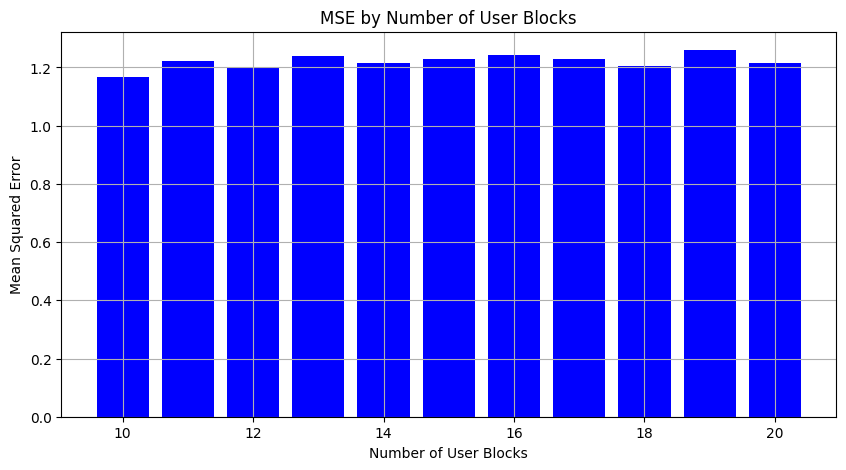

In [ ]:
data_path="ratings2k.csv"
cf = CollaborativeFiltering(data_path).run()

## Inference

### Khởi tạo

In [ ]:
data = spark.read.csv("ratings2k.csv", header=True, inferSchema=True)
training, test = data.randomSplit([0.7, 0.3], seed=123)

In [ ]:
### Dữ liệu đầu vào
data.show()

+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|    0|  73|  52|   4.0|
|    1|  36| 239|   3.0|
|    2|  72|  26|   1.0|
|    3|  59| 430|   2.5|
|    4|  72| 284|   3.0|
|    5|  36| 277|   3.0|
|    6|  72| 426|   4.0|
|    7|  18| 163|   3.0|
|    8|  67|  93|   4.0|
|    9|  59|  22|   3.5|
|   10|   8| 174|   2.0|
|   11|   5| 149|   2.0|
|   12|  26| 322|   3.5|
|   13|   8| 416|   4.0|
|   14|  31|  25|   2.0|
|   15|  41|  83|   2.0|
|   16|  25| 321|   3.0|
|   17|  47| 193|   3.0|
|   18|   9| 455|   4.0|
|   19|  43| 216|   3.5|
+-----+----+----+------+
only showing top 20 rows



In [ ]:
### Tập training và test theo tỉ lệ 7:3
training.show()
test.show()

+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|    0|  73|  52|   4.0|
|    1|  36| 239|   3.0|
|    3|  59| 430|   2.5|
|    4|  72| 284|   3.0|
|    5|  36| 277|   3.0|
|    7|  18| 163|   3.0|
|    8|  67|  93|   4.0|
|   10|   8| 174|   2.0|
|   11|   5| 149|   2.0|
|   14|  31|  25|   2.0|
|   15|  41|  83|   2.0|
|   16|  25| 321|   3.0|
|   17|  47| 193|   3.0|
|   19|  43| 216|   3.5|
|   20|   5| 170|   3.0|
|   21|  20| 176|   5.0|
|   22|  12| 368|   2.0|
|   24|  12| 428|   4.5|
|   25|  72|  49|   3.0|
|   26|  23| 465|   5.0|
+-----+----+----+------+
only showing top 20 rows

+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|    2|  72|  26|   1.0|
|    6|  72| 426|   4.0|
|    9|  59|  22|   3.5|
|   12|  26| 322|   3.5|
|   13|   8| 416|   4.0|
|   18|   9| 455|   4.0|
|   23|  13| 128|   5.0|
|   29|  59| 176|   4.0|
|   30|  72| 184|   4.0|
|   33|  64| 144|   5.0|
|   34|  25|  81|   4.0|
|   35|  25| 277|   3.0|

### ALS

In [ ]:
als = ALS(maxIter=10, regParam=0.1, userCol="user", itemCol="item", ratingCol="rating",
                  coldStartStrategy="drop", rank=10, numUserBlocks=10, numItemBlocks=10, implicitPrefs=False,
                  alpha=1.0, seed=None, checkpointInterval=10,
                  intermediateStorageLevel="MEMORY_AND_DISK", finalStorageLevel="MEMORY_AND_DISK",
                  nonnegative=False)
model = als.fit(training)
  # Generate predictions
predictions = model.transform(test)

# Evaluate the model
evaluator = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
mse = evaluator.evaluate(predictions)

In [ ]:
## MSE value
mse

1.1658481244588705

In [ ]:
## Chạy ALS cho numUserBlocks trong đoạn [10,20]
mse_values = []
for i in range(10,21):
  als = ALS(maxIter=10, regParam=0.1, userCol="user", itemCol="item", ratingCol="rating",
                  coldStartStrategy="drop", rank=10, numUserBlocks=i, numItemBlocks=10, implicitPrefs=False,
                  alpha=1.0, seed=None, checkpointInterval=10,
                  intermediateStorageLevel="MEMORY_AND_DISK", finalStorageLevel="MEMORY_AND_DISK",
                  nonnegative=False)
  model = als.fit(training)
    # Generate predictions
  predictions = model.transform(test)

  # Evaluate the model
  evaluator = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
  mse = evaluator.evaluate(predictions)
  mse_values.append(mse)

In [ ]:
## Các giá trị MSE trong đoạn [10,20]
mse_values

[1.1658481244588705,
 1.2207248844399676,
 1.2017101036073736,
 1.2409144254533861,
 1.2140621323713583,
 1.2299888246969504,
 1.2434299254110788,
 1.23049505085561,
 1.2035639337585773,
 1.259769096150575,
 1.2145379566575745]

# Req 2: Dự đoán giá chứng khoán.

In [ ]:
class PredictHVN:
    def __init__(self, path):
        self.data = spark.read.option("header", "true").csv(path)

    ## Create Fluctuation
    def create_fluctuation(self):
        self.data = self.data.withColumn("Ngay", to_date("Ngay", "dd/MM/yyyy")).orderBy(col("Ngay"))
        # Calculate the fluctuation
        window_spec = Window.orderBy(col("Ngay"))
        self.data = self.data.withColumn("Fluctuation", (col("HVN") - lag("HVN", 1).over(window_spec)) / lag("HVN", 1).over(window_spec))

        # Fill null values with 0 for the first row in Fluctuation column
        self.data = self.data.withColumn("Fluctuation", when(col("Fluctuation").isNull(), 0).otherwise(col("Fluctuation")))

    ## Create Fluctuation Vector
    def create_fluctuation_DF(self):
        # Create a window specification for the last 5 days
        vector_window_spec = Window.orderBy(col("Ngay")).rowsBetween(-4, 0)

        # Collect the fluctuation values of the past 5 days into an array
        self.data = self.data.withColumn("VectorFluctuation", collect_list("Fluctuation").over(vector_window_spec))

    def plot_mse_chart(self, train_mse, test_mse):
        # Plotting MSE values
        labels = ['Training', 'Test']
        mse_values = [train_mse, test_mse]

        x = np.arange(len(labels))
        width = 0.35

        fig, ax = plt.subplots()
        rects = ax.bar(x, mse_values, width, label='MSE')

        ax.set_ylabel('MSE')
        ax.set_title('MSE on Training and Test Dataset')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate('{}'.format(round(height, 2)),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')
        autolabel(rects)

        fig.tight_layout()

        plt.show()

    def predict(self):
        # Filter out rows where the size   of VectorFluctuation is not equal to 5
        self.data = self.data.filter(size(col("VectorFluctuation")) == 5)

        # Define a UDF to convert array<double> to Vector
        array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

        # Apply UDF to convert array column to Vector
        self.data = self.data.withColumn("Features", array_to_vector_udf(col("VectorFluctuation")))

        # Split data into training and testing sets
        train_data, test_data = self.data.randomSplit([0.8, 0.2], seed=1234)

        # Create and train the Linear Regression model
        lr = LinearRegression(featuresCol="Features", labelCol="Fluctuation")
        lr_model = lr.fit(train_data)

        # Evaluate the model on the training set
        train_summary = lr_model.summary
        train_mse = train_summary.meanSquaredError

        # Evaluate the model on the test set
        test_summary = lr_model.evaluate(test_data)
        test_mse = test_summary.meanSquaredError

        # Plot the MSE chart
        self.plot_mse_chart(train_mse, test_mse)

        # Show the predictions
        predictions = lr_model.transform(test_data)
    def run(self):
        self.create_fluctuation()
        self.create_fluctuation_DF()
        self.predict()

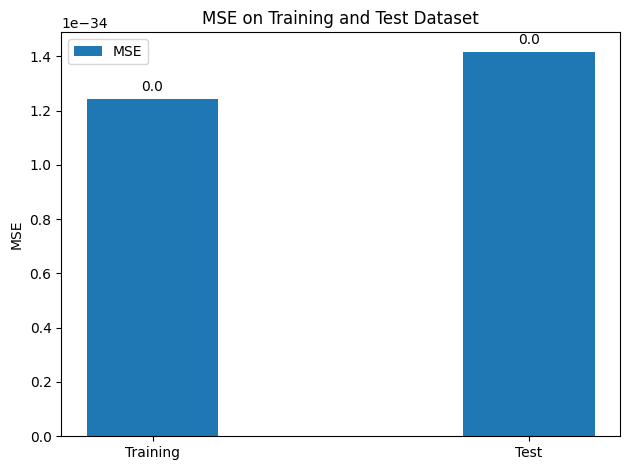

In [ ]:
path = "/content/stockHVN2022.csv"
PredictHVN(path).run()